In [1]:
import numpy as np
from gaussians import Gaussians
import json
import cv2
import pickle
import torch
from torch import nn
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
from modules.bilinear_interpolation import BilinearInterpolation
from google.cloud import storage
import math

In [2]:
def calc_dists(preds, target):
  # x1,y1 = preds
  # x2, y2 = target

  # y = np.power((y2 - y1),2)
  # x = np.power((x2 - x1),2)
  # dist = np.sqrt(y + x)

  pred_arr = np.array(preds)
  target_arr = np.array(target)
  dist = np.linalg.norm(pred_arr - target_arr)

  return dist

In [3]:
def threshold_acc(dists, threshold):
  return (dists < threshold).sum()

In [4]:
def evaluation(model_output, ground_truth, kpt, pck_mult, pckh_mult):

  # Threshold Calculation
  head1_cpu = ground_truth[0,8].cpu().detach().double().numpy()
  head1_argmax = np.argmax(head1_cpu)
  head1_unravel = np.unravel_index(head1_argmax, (46,46))

  head2_cpu = ground_truth[0,9].cpu().detach().double().numpy()
  head2_argmax = np.argmax(head2_cpu)
  head2_unravel = np.unravel_index(head2_argmax, (46,46))

  torso1_cpu = ground_truth[0,6].cpu().detach().double().numpy()
  torso1_argmax = np.argmax(torso1_cpu)
  torso1_unravel = np.unravel_index(torso1_argmax, (46,46))

  torso2_cpu = ground_truth[0,7].cpu().detach().double().numpy()
  torso2_argmax = np.argmax(torso2_cpu)
  torso2_unravel = np.unravel_index(torso2_argmax, (46,46))

  if ((torso1_unravel[0] < 1) or (torso1_unravel[1] < 1) or (torso2_unravel[0] < 1) or (torso2_unravel[1] < 1) or (head1_unravel[0] < 1) or (head1_unravel[1] < 1) or (head2_unravel[0] < 1) or (head2_unravel[1] < 1)):
    return -1, -1, -1, -1

  head_dist = calc_dists(head1_unravel, head2_unravel)
  torso_dist = calc_dists(torso1_unravel, torso2_unravel)

  # head_dist = np.linalg.norm(head1_unravel - head2_cpu) # neck to head
  # torso_dist = np.linalg.norm(torso1_cpu - torso2_cpu) # waist to torso

  pckh_threshold = pckh_mult * head_dist
  pck_threshold = pck_mult * torso_dist

  # print("THRESHOLDS")
  # print(pckh_threshold)
  # print(pck_threshold)
  
  pckh = 0
  pck = 0
  count = 0

  for j in range(16): #each joint
    if(not (kpt[j, 0] < 0 or kpt[j, 1] < 0)):
      model_cpu = model_output[0,j].cpu().detach().double().numpy()
      model_argmax = np.argmax(model_cpu)
      model_unravel = np.unravel_index(model_argmax,(46,46))

      # print("Model Unravel " + str(j))
      # print(model_unravel)

      gt_cpu = ground_truth[0,j].cpu().detach().double().numpy()
      gt_argmax = np.argmax(gt_cpu)
      gt_unravel = np.unravel_index(gt_argmax,(46,46))

      # print("Ground Truth Unravel " + str(j))
      # print(gt_unravel)

      dist_heatmap = calc_dists(model_unravel, gt_unravel)
      # print("Dist Heatmap")
      # print(dist_heatmap)
      pckh += threshold_acc(dist_heatmap, pckh_threshold)
      pck += threshold_acc(dist_heatmap, pck_threshold)

      count += 1

  # test distance accuracy function
  pck_avg = pck/count
  pckh_avg = pckh/count

  return pck_avg, pckh_avg, math.pi * pck_threshold * pck_threshold, math.pi * pckh_threshold * pckh_threshold

In [17]:
# For PCK/PCKH

with open('annotations/valid.json') as f:
  data = json.load(f)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""

storage_client = storage.Client("pose_estimation_2")
bucket = storage_client.get_bucket('pose_estimation_2_dataset_mpii')

img = None
kpt = None
gaussian = None
g_list = None
device = None
orig_img = None


filename = 'training_output_2021-05-02 15_21_31.903697_epoch24.pkl'
with open(filename,'rb') as infile:
  model = pickle.load(infile)

fivepcks = []
twopcks = []
fivepckhs = []
eightpckhs = []
fivepck_areas = []
twopck_areas = []
fivepckh_areas = []
eightpckh_areas = []
print(len(data))
for i in range(len(data)):
  print(f'{i} out of {len(data)}')
  img_name = data[i]['image']
  #img = data[i]['image']
  # img = cv2.imread(img_name)
  blob = bucket.blob('MPII/images/' +  img_name)
  blob.content_type = 'image/jpeg'
  image = np.asarray(bytearray(blob.download_as_string()))
  img = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
  # print(type(img))
  kpt = np.asarray(data[i]['joints'], dtype=np.int32)
  if img.shape[0] != 368 or img.shape[1] != 368:
      kpt[:, 0] = kpt[:, 0] * (368 / img.shape[1])
      kpt[:, 1] = kpt[:, 1] * (368 / img.shape[0])
      img = cv2.resize(img, (368, 368))
      img = np.array(img)
  #print(kpt[0])
  #print(kpt.shape)
  gaussian = Gaussians()
  g_list = []
  g_list.append(kpt)
  device = "cuda"
  orig_img = img

  heatmap = gaussian.expected_to_gaussian(g_list).to(device)

  # Model
  img_cuda = torch.Tensor(img).unsqueeze(0).permute(0, 3, 1, 2).to(device)
  output = model(img_cuda)
  softmax = nn.Softmax(dim=2)
  # # get Softmax over 2D image channels
  # input_view = output.view(output.shape[0], output.shape[1], -1)
  # output_view = softmax(input_view)
  # output = output_view.view(output.shape)

  # output1 = output.cpu().detach().numpy()
  # # output = np.transpose(output * 255.0)

  # # cv2_imshow((heatmap[0,0] * 1000))
  # amax = np.argmax(heatmap.cpu().detach().numpy()[0,8])
  # unrav = np.unravel_index(amax, (46,46))
  # print(unrav)
  # plt.imshow(heatmap.double().cpu().detach().numpy()[0,8])
  # # plt.imshow(orig_img)



  pck, pckh, pck_area, pckh_area = evaluation(output, heatmap, kpt, 0.2, 0.5)
  # print("EVALUATIONS")
  # print(pck)
  # print(pckh)
  # print(pck_area)
  # print(pckh_area)
  # if pck >= 0:
  twopcks.append(pck)
    # twopck_areas.append(pck_area)
  # if pckh >= 0:
  fivepckhs.append(pckh)
    # fivepckh_areas.append(pckh_area)

  # pck, pckh, pck_area, pckh_area = evaluation(output, heatmap, kpt, 0.5, 0.8)
  # print("EVALUATIONS")
  # print(pck)
  # print(pckh)
  # print(pck_area)
  # print(pckh_area)
  # if pck >= 0:
  # fivepcks.append(pck)
  #   # fivepck_areas.append(pck_area)
  # # if pckh >= 0:
  # eightpckhs.append(pckh)
    # eightpckh_areas.append(pckh_area)
  # if i % 100 == 0:
    # print(f'running 0.2 pck average: {sum(twopcks) / len(twopcks)}')
    # print(f'running 0.2 pck area average: {sum(twopck_areas) / len(twopck_areas)}')
    # print(f'running 0.5 pckh average: {sum(fivepckhs) / len(fivepckhs)}')
    # print(f'running 0.5 pckh area average: {sum(fivepckh_areas) / len(fivepckh_areas)}')
    # print(f'running 0.5 pck average: {sum(fivepcks) / len(fivepcks)}')
    # print(f'running 0.5 pck area average: {sum(fivepck_areas) / len(fivepck_areas)}')
    # print(f'running 0.8 pckh average: {sum(eightpckhs) / len(eightpckhs)}')
    # print(f'running 0.8 pckh area average: {sum(eightpckh_areas) / len(eightpckh_areas)}')
# print(f'final 0.2 pck average: {sum(twopcks) / len(twopcks)}')
# print(f'final 0.2 pck area average: {sum(twopck_areas) / len(twopck_areas)}')
# print(f'final 0.5 pckh average: {sum(fivepckhs) / len(fivepckhs)}')
# print(f'final 0.5 pckh area average: {sum(fivepckh_areas) / len(fivepckh_areas)}')
# print(f'final 0.5 pck average: {sum(fivepcks) / len(fivepcks)}')
# print(f'final 0.5 pck area average: {sum(fivepck_areas) / len(fivepck_areas)}')
# print(f'final 0.8 pckh average: {sum(eightpckhs) / len(eightpckhs)}')
# print(f'final 0.8 pckh area average: {sum(eightpckh_areas) / len(eightpckh_areas)}')


ut of 2958
1797 out of 2958
1798 out of 2958
1799 out of 2958
1800 out of 2958
1801 out of 2958
1802 out of 2958
1803 out of 2958
1804 out of 2958
1805 out of 2958
1806 out of 2958
1807 out of 2958
1808 out of 2958
1809 out of 2958
1810 out of 2958
1811 out of 2958
1812 out of 2958
1813 out of 2958
1814 out of 2958
1815 out of 2958
1816 out of 2958
1817 out of 2958
1818 out of 2958
1819 out of 2958
1820 out of 2958
1821 out of 2958
1822 out of 2958
1823 out of 2958
1824 out of 2958
1825 out of 2958
1826 out of 2958
1827 out of 2958
1828 out of 2958
1829 out of 2958
1830 out of 2958
1831 out of 2958
1832 out of 2958
1833 out of 2958
1834 out of 2958
1835 out of 2958
1836 out of 2958
1837 out of 2958
1838 out of 2958
1839 out of 2958
1840 out of 2958
1841 out of 2958
1842 out of 2958
1843 out of 2958
1844 out of 2958
1845 out of 2958
1846 out of 2958
1847 out of 2958
1848 out of 2958
1849 out of 2958
1850 out of 2958
1851 out of 2958
1852 out of 2958
1853 out of 2958
1854 out of 2958
185

In [28]:

zipped = list(zip(range(len(data)), twopcks))
my_sorted = sorted(zipped, key=lambda x: x[1])
print(my_sorted[-10:])

print(data[2722]['image'])

# image 184, 

# heatmap = gaussian.expected_to_gaussian(g_list).to(device)

# # Model
# filename = 'epoch_overfit.pkl'
# infile = open(filename,'rb')
# model = pickle.load(infile)
# img_cuda = torch.Tensor(img).unsqueeze(0).permute(0, 3, 1, 2).to(device)
# output = model(img_cuda)
# softmax = nn.Softmax(dim=2)
# # get Softmax over 2D image channels
# input_view = output.view(output.shape[0], output.shape[1], -1)
# output_view = softmax(input_view)
# output = output_view.view(output.shape)
# infile.close()

# print(heatmap.shape)
# print(output.shape)

[(927, 0.5625), (1080, 0.5625), (1168, 0.5625), (1614, 0.5625), (2123, 0.5625), (2391, 0.5625), (2630, 0.5625), (2769, 0.5625), (2866, 0.5625), (2772, 0.625)]
080436963.jpg


In [7]:
pck, pckh = evaluation(output, heatmap, kpt)
print("EVALUATIONS")
print(pck)
print(pckh)
# print("CALC_DISTS")


THRESHOLDS
3.1622776601683795
0.4
EVALUATIONS
0.375
0.9375


In [8]:
print(output[0,0,0,0] - output[0,0,0,1])
# print(heatmap[0,0].max())

tensor(3.3140e-06, device='cuda:0', grad_fn=<SubBackward0>)


(10, 23)


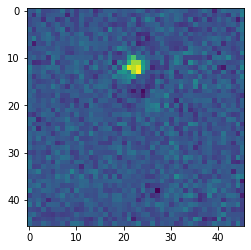

In [9]:

output1 = output.cpu().detach().numpy()
# output = np.transpose(output * 255.0)

# cv2_imshow((heatmap[0,0] * 1000))
amax = np.argmax(output1[0,0])
unrav = np.unravel_index(amax, (46,46))
print(unrav)

plt.imshow(output1[0,8])


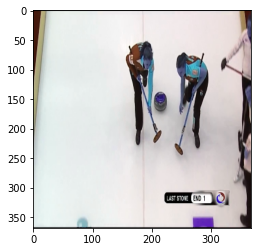

In [10]:
plt.imshow(orig_img)

(25, 22)


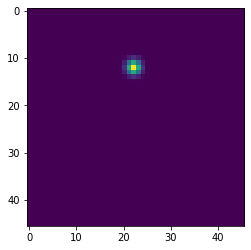

In [11]:
heatmap0 = heatmap.cpu().detach().double().numpy()
heatmap1 = np.argmax(heatmap0[0,0])
hm_unrav = np.unravel_index(heatmap1, (46,46))
print(hm_unrav)

plt.imshow((heatmap0[0,8]))